(log-reg-notebook)=
# Modello di regressione logistica

In questo capitolo, ci concentriamo sulla regressione logistica bivariata, una tecnica statistica fondamentale per analizzare le relazioni tra una variabile binaria di risultato e una singola variabile indipendente. Esploreremo il processo di stima dei coefficienti del modello utilizzando un approccio bayesiano, il quale ci permette di ottenere stime a posteriori più informative e di calcolare intervalli di credibilità per i coefficienti.

Inoltre, forniremo un'interpretazione dei risultati ottenuti dalla regressione logistica. Spiegheremo come i coefficienti influenzano la probabilità di successo della variabile binaria di risultato e come interpretare il loro segno e magnitudo. Questo ci aiuterà a comprendere come la variabile indipendente contribuisce al cambiamento nella probabilità di ottenere un particolare risultato.

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In questo tutorial, utilizzeremo un set di dati forniti dal sito di `bambi` per illustrare il modello di regressione logistica. Questi dati provengono dallo studio pilota del 2016. Lo studio completo includeva 1200 persone, ma in questo caso, è stato selezionato un sottoinsieme di 487 persone che hanno risposto a una domanda riguardante se avrebbero votato per Hillary Clinton o Donald Trump.

In [3]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


La nostra variabile di esito è `vote`, che indica le risposte delle persone alla seguente domanda:

"If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?"

In [4]:
data["vote"].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

Per rendere l'analisi più semplice, considereremo solo le risposte delle persone che hanno indicato di voler votare per Clinton o Trump. Modelleremo quindi la probabilità di voto per Clinton.

In [5]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Per l'analisi di questi dati, potremmo essere tentati di utilizzare il modello lineare tradizionale; tuttavia, ciò non è possibile in questo caso a causa delle specifiche caratteristiche dei dati. In primo luogo, la variabile $Y$ è di tipo Bernoulliano, ovvero può assumere solo due valori possibili: 0 e 1, corrispondenti a due esiti distinti ("voto per Clinton" o "voto per Trump"). Questa natura discreta e categorica della variabile $Y$ rende incompatibile il modello di regressione tradizionale, che invece è concepito per variabili dipendenti continue.

Inoltre, il modello lineare tradizionale presuppone che l'aspettativa di $Y$ ($E(Y \mid X)$) sia un valore compreso nell'intervallo da meno infinito a più infinito, mentre $Y$ può assumere solo i valori 0 e 1. Questo aspetto incompatibile limita ulteriormente l'adeguatezza del modello lineare tradizionale per descrivere i dati in questione.

Per superare queste problematiche, possiamo adottare un approccio diverso: prevedere non il valore atteso di $Y$ direttamente, bensì il valore atteso di una sua trasformazione. Questa trasformazione di $Y$ viene chiamata "funzione link". Nella regressione logistica, la funzione link utilizzata è il logit, ovvero il logaritmo dell'odds ratio, rappresentato come:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)},
$$

dove $\pi$ rappresenta la probabilità di $Y$ essere 1. Il logit può assumere valori nell'intervallo da meno infinito a più infinito, rendendo così appropriato il modello di regressione logistica per dati con variabili di tipo Bernoulliano.

Pertanto, il modello di regressione logistica è essenzialmente un modello di regressione lineare che si focalizza sulla previsione di una trasformazione della variabile Bernoulliana $Y$, utilizzando il logaritmo dell'odds ratio come funzione link.

In modo equivalente, la probabilità di $Y$, indicata come $\pi$, può essere espressa come funzione del predittore lineare $\eta = \beta_0 + \beta_1 X$:

$$
\pi = \frac{e^\eta}{1 + e^\eta}= \frac{1}{1 + e^{-\eta}}.
$$

In questo modo, otteniamo un modello non lineare.

Nel nostro esempio, utilizzeremo un modello di regressione logistica per stimare la probabilità di votare per Clinton in funzione dell'età. Il nostro obiettivo è quindi modellare $\pi = P(Y = 1)$, ovvero la probabilità di votare per Clinton, utilizzando solo l'età come variabile esplicativa.

La regressione logistica collega il logit di $\pi$ a un predittore o a una combinazione lineare di predittori. Nella nostra situazione, l'equazione matematica del modello sarà la seguente:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X,
$$

dove $X$ rappresenta l'età.

Inoltre, per utilizzare l'approccio bayesiano, dobbiamo specificare una distribuzione a priori per i parametri e una funzione di verosimiglianza. Nella nostra analisi, utilizzeremo le distribuzioni a priori predefinite di Bambi e la verosimiglianza sarà il prodotto delle prove Bernoulliane, ovvero il prodotto delle probabilità $\prod_{i=1}^{n}{p_i^{y_i}(1-p_i)^{1-y_i}}$, dove $p_i = P(Y=1)$ e $y_i = 1$ se l'intenzione di voto è per Clinton e $y_i = 0$ se per Trump.

### Specificare e adattare il modello in Bambi

La specificazione e l'adattamento del modello sono semplici. Per utilizzare Bambi, è sufficiente specificare il modello utilizzando la sintassi delle formule e passare l'argomento `family` corretto. È importante notare la sintassi opzionale utilizzata sul lato sinistro della formula: `vote[clinton]` indica a Bambi di modellare la probabilità che `vote=='clinton'`, invece della probabilità che `vote=='trump'`.

Sul lato destro della formula, utilizziamo `age` per indicare a Bambi che vogliamo utilizzare `age` come unica variabile esplicativa nel modello.

In [6]:
clinton_model = bmb.Model(
    "vote['clinton'] ~ age", clinton_data, family="bernoulli"
)

In [7]:
clinton_fitted = clinton_model.fit(
    draws=2000,
    target_accept=0.85,
    random_seed=RANDOM_SEED,
    idata_kwargs={"log_likelihood": True},
)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


Possiamo stampare l'oggetto `clinton_model` per visualizzare informazioni sulla distribuzione della risposta, la funzione link e le distribuzioni a priori.

In [8]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, age]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'age'}>], dtype=object)

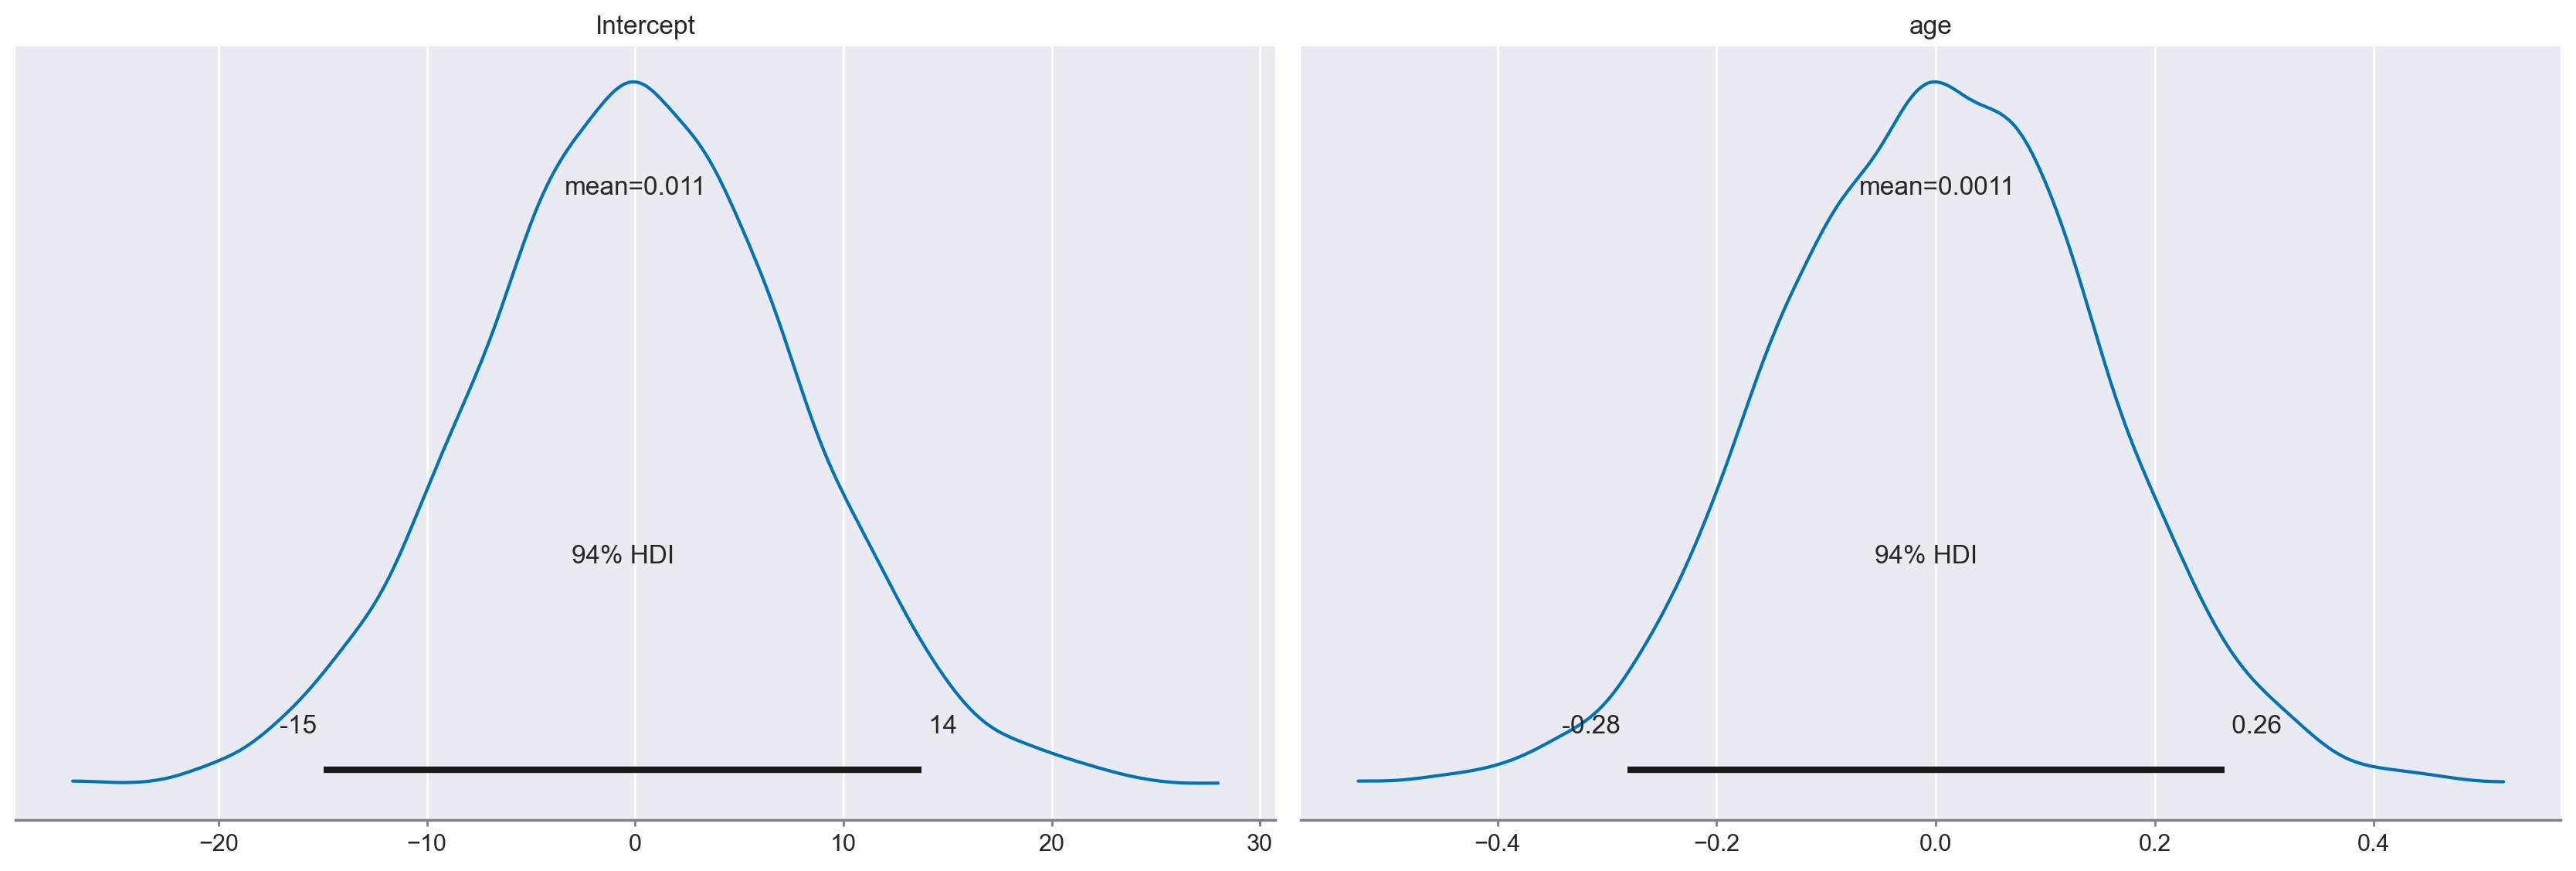

In [9]:
clinton_model.plot_priors()

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'age'}>, <Axes: title={'center': 'age'}>]],
      dtype=object)

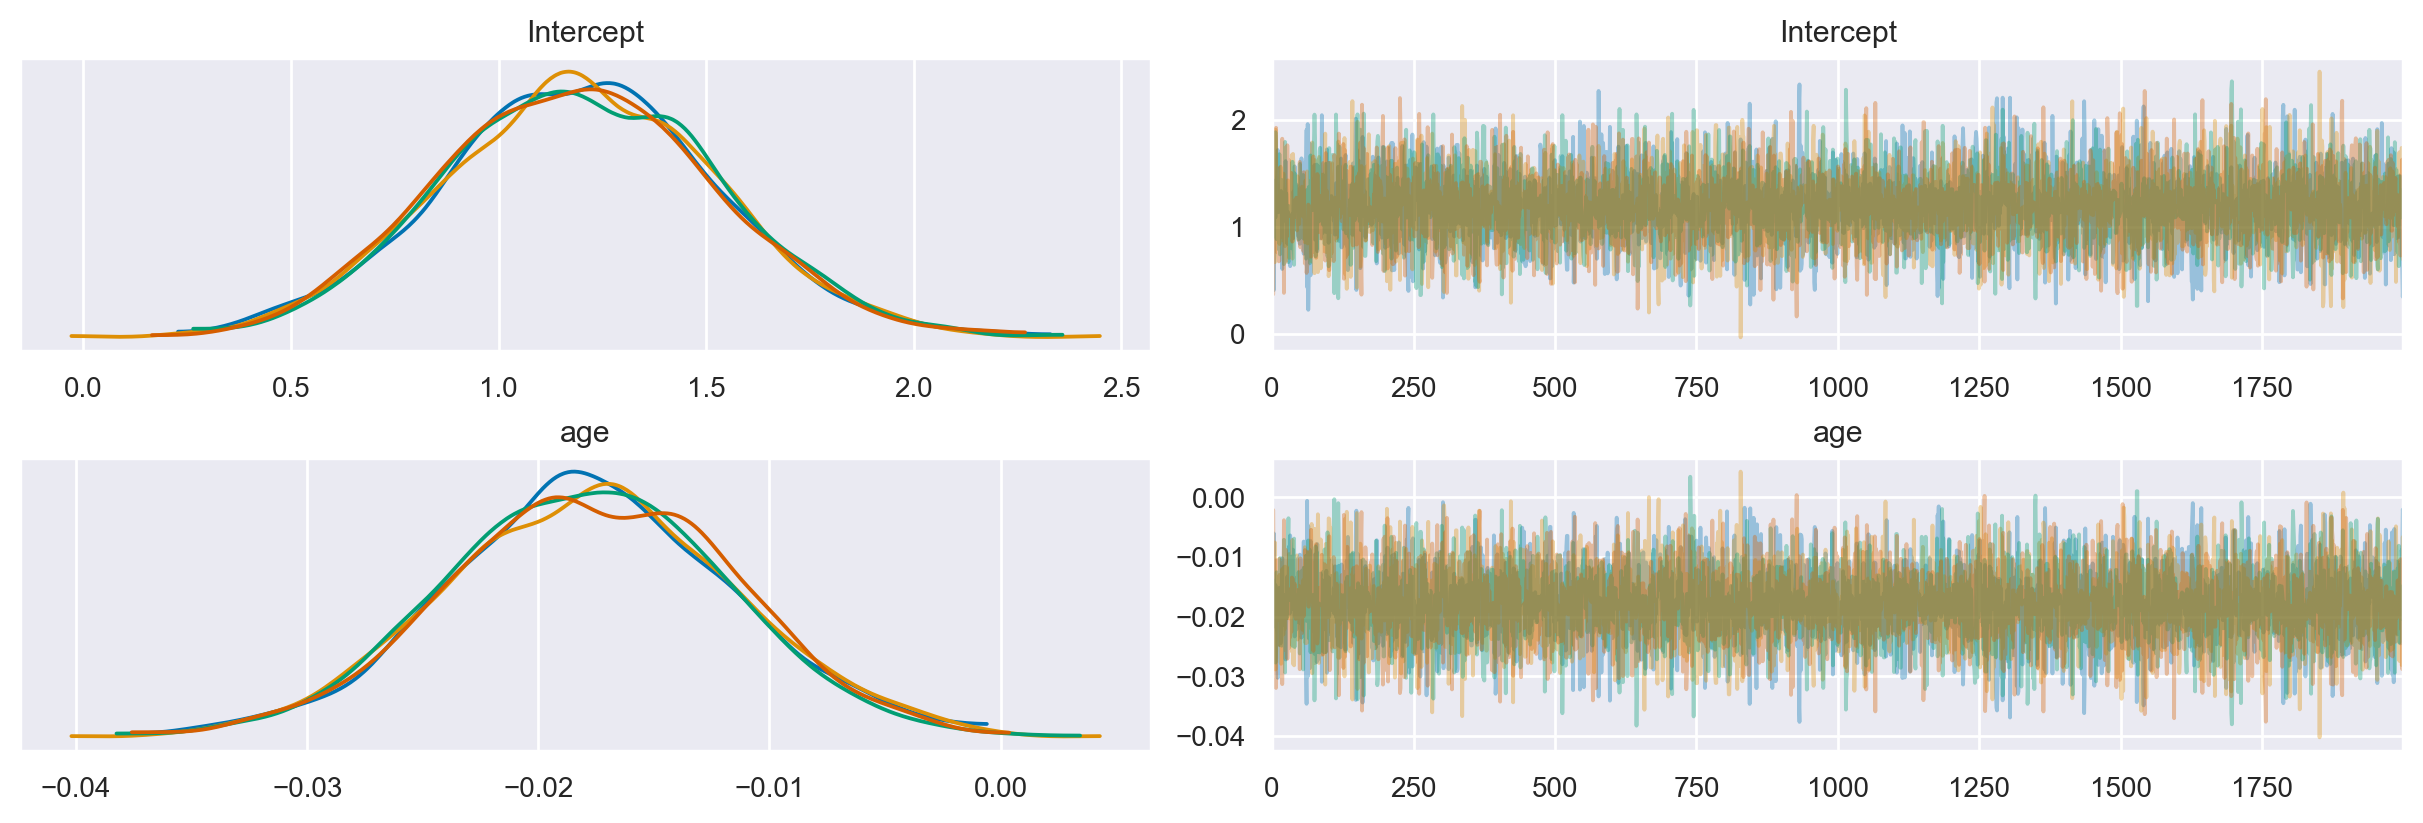

In [10]:
az.plot_trace(clinton_fitted, compact=False)

In [11]:
az.summary(clinton_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.195,0.330,0.591,1.828,0.004,0.003,8034.0,5956.0,1.0
age,-0.018,0.006,-0.029,-0.006,0.000,0.000,8090.0,5906.0,1.0


Pertanto, l'equazione del modello di regressione logistica è:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = 1.195 - 0.018 \cdot \text{età}.
$$


## Interpretazione dei coefficienti nella regressione logistica

Consideriamo il caso generale. Sia $Y$ un indicatore binario di un certo evento di interesse che si verifica con probabilità $\pi$. Consideriamo il modello di regressione logistica di $Y$ con i predittori $(X_1, X_2, \ldots, X_p)$:

$$
\log(\text{odds}) = \log\left(\frac{\pi}{1 - \pi}\right) = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p.
$$

### Interpretazione di $\beta_0$

Quando tutti i predittori $(X_1, X_2, \ldots, X_p)$ sono pari a 0, $\beta_0$ rappresenta il log odds dell'evento di interesse e $e^{\beta_0}$ rappresenta gli odds.

### Interpretazione di $\beta_1$

Quando controlliamo gli altri predittori $(X_2, \ldots, X_p)$, sia $\text{odds}_x$ l'odds dell'evento di interesse quando $X_1 = x$, e sia $\text{odds}_{x+1}$ l'odds quando $X_1 = x+1$. Quindi, quando $X_1$ aumenta di 1, da $x$ a $x+1$, $\beta_1$ rappresenta il cambiamento tipico nel log odds, e $e^{\beta_1}$ rappresenta il cambiamento tipico moltiplicativo negli odds:

$$
\beta_1 = \log(\text{odds}_{x+1}) - \log(\text{odds}_x) \quad \text{e} \quad e^{\beta_1} = \frac{\text{odds}_{x+1}}{\text{odds}_x}.
$$


Per l'esempio in discussione, interpretando i coefficienti, possiamo dire quanto segue. L'intercetta rappresenta il log(odds) di successo quando l'età è pari a zero. In altre parole, per un'età di zero anni, ci aspettiamo che il logit sia 1.195. 

Possiamo anche dire che, per un'età pari a 0, gli odds di successo ($\pi / (1-\pi)$) sono pari a

In [19]:
np.exp(1.195)

3.3035577705016714

e la probabilità di un voto per Clinton è

In [20]:
np.exp(1.195) / (1 + np.exp(1.195))

0.7676341173216252

Tuttavia, in questo caso, l'intercetta non fornisce informazioni utili. Se avessimo trasformato i dati codificando l'età come scarti dalla media, le interpretazioni precedenti sarebbero riferite all'età media del campione, il che avrebbe più senso.

Passiamo ora al coefficiente $\beta_1$. Sulla scala lineare dei logit, il coefficiente $\beta_1$ rappresenta semplicemente la pendenza: per un cambiamento unitario dell'età, i logit del voto per Clinton diminuiscono di -0.018. Tuttavia, è più facile interpretare questo risultato sulla scala non lineare degli odds, dove questa variazione è moltiplicativa. Per ogni anno di aumento dell'età, gli odds di un voto per Clinton diminuiscono moltiplicativamente di $e^{\beta_1}$ volte:

In [17]:
np.exp(-0.018)

0.9821610323583008

Poiché la relazione di probabilità è una curva a S più complessa, non possiamo interpretare facilmente il coefficiente $\beta_1$ su questa scala. È invece preferibile rappresentare graficamente come varia la probabilità attesa di "successo" al variare dell'età. La rappresentazione di questa relazione, basata sulle stime a posteriori del modello, è fornita di seguito.

In [12]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

,age
0,18
1,19
2,20
3,21
4,22
...,...
214,86
215,87
216,88
217,89


In [13]:
clinton_model.predict(clinton_fitted, data=new_data)

In [14]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

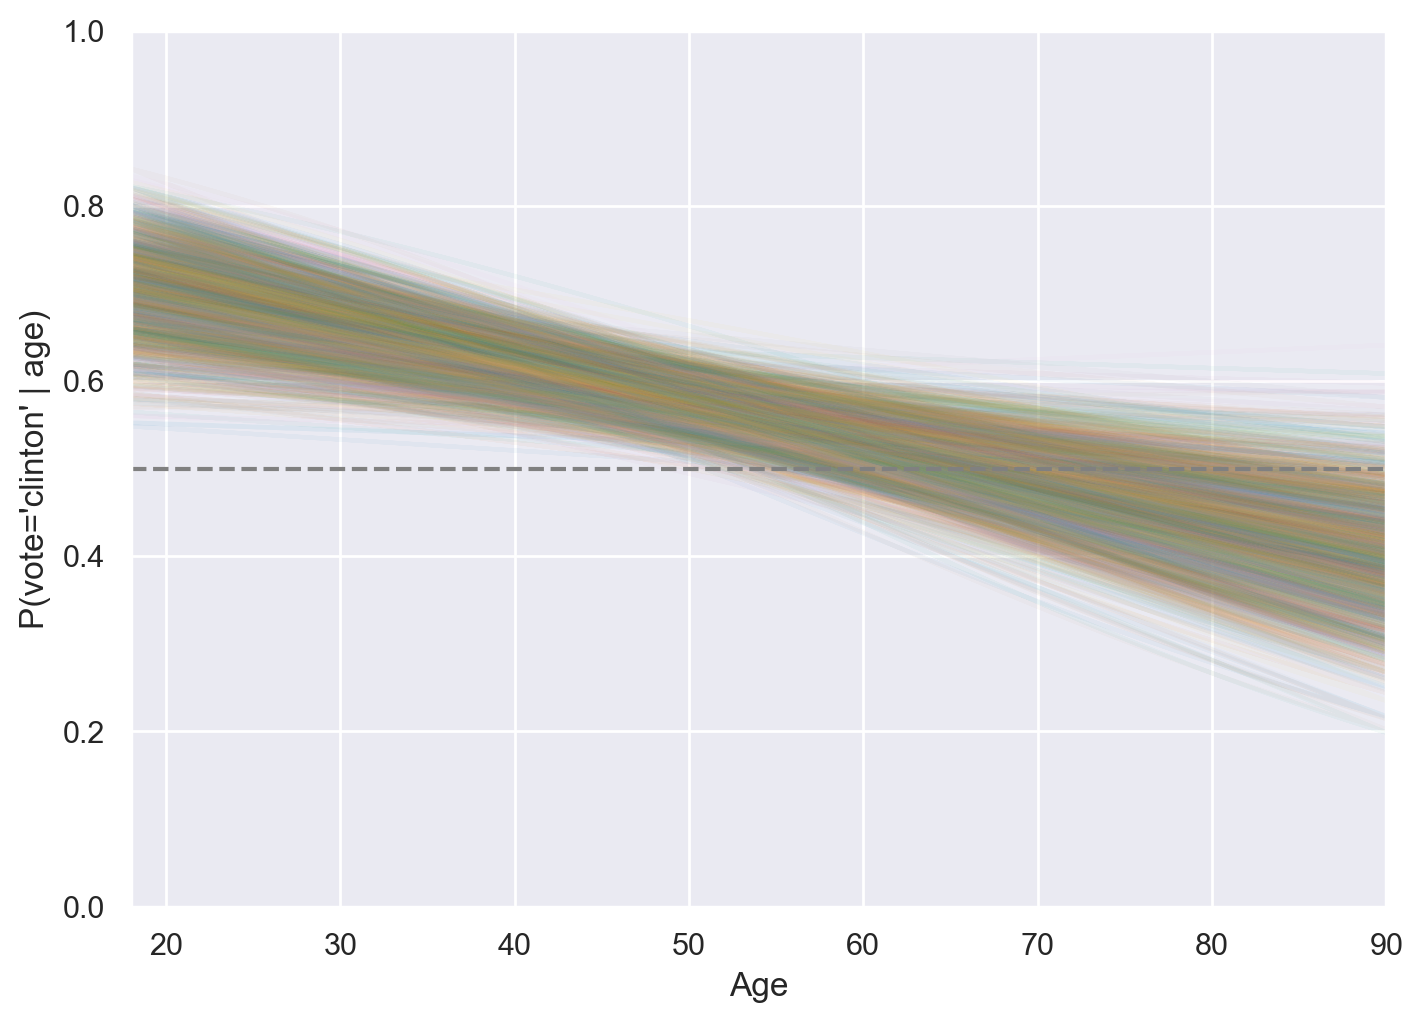

In [15]:
_, ax = plt.subplots(figsize=(7, 5))

ax.plot(new_data.age, vote_posterior, alpha=0.04)

# Adding a dashed horizontal line at y=0.5 (50% probability)
ax.axhline(y=0.5, color='gray', linestyle='dashed')

ax.set_ylabel("P(vote='clinton' | age)")
ax.set_xlabel("Age")
ax.set_ylim(0, 1)
ax.set_xlim(18, 90)

plt.show()


Possiamo interpretare il grafico precedente nel seguente modo: fino a circa 65 anni, l'intenzione di voto per Clinton è maggiore dell'intenzione di voto per Trump; dopo i 65 anni, la situazione si inverte.

Il fatto che la figura riporti molteplici curve (2000 nel caso presente) ci informa sulla variabilità delle predizioni del modello.

Possiamo concludere affermando che l'aspetto più importante del modello di regressione logistica riguarda l'interpretazione dei coefficienti. Abbiamo visto che il modo migliore per fornire tale interpretazione è attraverso la rappresentazione grafica della relazione tra la predizione della probabilità di successo e la variabile $X$. Questo approccio funziona bene quando il modello include una sola variabile indipendente. Tuttavia, nel caso di più variabili indipendenti, questa strategia grafica non può essere utilizzata e l'interpretazione dei risultati del modello di regressione logistica diventa più complessa. In quei casi, l'interpretazione dei risultati si basa sulla direzione (positiva o negativa) e sulla magnitudine (valore) dei coefficienti associati a ciascuna variabile.



## Funzione logistica

Per chi fosse interessato, possiamo esaminare i passaggi algebrici che che trasformano l'equazione iniziale $\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X$ nell'equazione $\pi = \frac{e^\eta}{1 + e^\eta}$.

Partiamo dall'equazione iniziale:

   $$\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X.$$
   
Applichiamo la funzione esponenziale ad entrambi i lati dell'equazione per eliminare il logaritmo:

   $$\exp\left(\log{\left(\frac{\pi}{1 - \pi}\right)}\right) = \exp(\beta_0 + \beta_1 X).$$

Utilizziamo la proprietà $\exp(\log(a)) = a$ per semplificare il lato sinistro dell'equazione:

   $$\frac{\pi}{1 - \pi} = \exp(\beta_0 + \beta_1 X).$$

Moltiplichiamo entrambi i lati dell'equazione per $(1 - \pi)$:

   $$\pi = (1 - \pi) \exp(\beta_0 + \beta_1 X).$$

Dalla precedente equazione $\pi = (1 - \pi) \exp(\beta_0 + \beta_1 X)$, moltiplichiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = (1 - \pi) \cdot \exp(\beta_0 + \beta_1 X) \cdot \exp(-\beta_0 - \beta_1 X).$$

Semplificando, otteniamo:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = (1 - \pi).$$

Ora, dividiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\frac{\pi \cdot \exp(-\beta_0 - \beta_1 X)}{\exp(-\beta_0 - \beta_1 X)} = \frac{(1 - \pi)}{\exp(-\beta_0 - \beta_1 X)}.$$

Semplificando ulteriormente, abbiamo:

$$\pi = \frac{1 - \pi}{\exp(-\beta_0 - \beta_1 X)}.$$

Ora, moltiplichiamo entrambi i lati per $\exp(-\beta_0 - \beta_1 X)$:

$$\pi \cdot \exp(-\beta_0 - \beta_1 X) = 1 - \pi.$$

Mettiamo $\pi$ da un lato e semplifichiamo il lato destro:

$$\pi + \pi \cdot \exp(-\beta_0 - \beta_1 X) = 1.$$

Ora, estraiamo $\pi$ come un fattore comune:

$$\pi \cdot (1 + \exp(-\beta_0 - \beta_1 X)) = 1.$$

Infine, isoliamo $\pi$ dividendo entrambi i lati per $(1 + \exp(-\beta_0 - \beta_1 X))$:

$$\pi = \frac{1}{1 + \exp(-\beta_0 - \beta_1 X)}.$$

Ponendo $\eta = \beta_0 + \beta_1 X$, possiamo scrivere la stessa espressione come:

$$\pi = \frac{\exp(\eta)}{1 + \exp(\eta)},$$

o anche come:

$$\pi = \frac{1}{1 + \exp(-\eta)}.$$

Questa forma finale è nota come funzione logistica o funzione sigmoide, ed è utilizzata per mappare il logit delle probabilità $\eta$ nella probabilità stessa $\pi$.


## Commenti e considerazioni finali

In questo capitolo abbiamo esplorato il modello di regressione logistica, una tecnica statistica fondamentale per analizzare le relazioni tra variabili binarie e variabili indipendenti continue o categoriche. Ci siamo concentrati sulla probabilità di successo e abbiamo scoperto come il modello di regressione logistica utilizzi il logit delle probabilità per modellare questa relazione. La funzione logit trasforma l'intervallo di probabilità da 0 a 1 in un intervallo da meno infinito a più infinito, permettendo al modello di adattarsi alla regressione.

Abbiamo inoltre approfondito l'importanza dell'interpretazione dei coefficienti nel modello di regressione logistica e come essi influenzino la probabilità di successo. Quando il modello coinvolge una sola variabile indipendente, la visualizzazione grafica delle probabilità attese può risultare utile per comprendere meglio i risultati. Tuttavia, quando più variabili sono coinvolte, l'analisi dei coefficienti diventa fondamentale per interpretare gli effetti congiunti delle variabili sul risultato. 

Abbiamo anche introdotto l'approccio bayesiano per ottenere una stima a posteriori dei parametri. Questa metodologia ci permette di avere un'idea più completa delle incertezze associate alle stime dei coefficienti. Attraverso l'aggiornamento bayesiano, possiamo ottenere intervalli di credibilità al livello di certezza soggettiva desiderato, rendendo l'analisi ancora più informativa e interpretabile.

## Watermark

In [48]:
%watermark -n -u -v -iv -w

Last updated: Wed Aug 02 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.12.0

arviz     : 0.16.0
pandas    : 1.5.3
seaborn   : 0.12.2
numpy     : 1.25.0
bambi     : 0.12.0
matplotlib: 3.7.1

Watermark: 2.4.3

